In [1]:
import os
import math
import scipy
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import randint
from scipy.stats import loguniform
from IPython.display import display

from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]

import warnings 
warnings.filterwarnings('ignore')

!pip install openpyxl

#### So now we aim to create a MRF Table using the above dataset


In [2]:
df = pd.read_excel('/kaggle/input/customer-segmentation/Online Retail.xlsx') 
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


### Strategy
* We multiply Quantity and UnitPrice to generate the "Income" Column
* We extract the date from "InvoiceDate" to generate the "Recency" column
* The InvoiceNo acts as the "Frequency" for a customer

In [4]:
data = df.sample(100000,random_state=42)

In [5]:
data["InvoiceDate"] = data["InvoiceDate"].dt.date
data["TotalSum"] = data["Quantity"] * data["UnitPrice"]
snapshot_date = max(data.InvoiceDate) + datetime.timedelta(days=1)
customers = data.groupby(['CustomerID']).agg({'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
                                            'InvoiceNo': 'count','TotalSum': 'sum'})
customers.rename(columns = {'InvoiceDate': 'Recency','InvoiceNo': 'Frequency',
                            'TotalSum': 'MonetaryValue'}, inplace=True)
#customers["MonetaryValue"] = customers["MonetaryValue"].abs()
#customers = customers[customers["MonetaryValue"] > 0 ] 
display(customers.head())

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346.0,326,1,77183.60
12347.0,3,27,588.48
12348.0,319,5,443.52
12349.0,19,15,578.21
12350.0,311,2,42.90


In [6]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4092 entries, 12346.0 to 18287.0
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Recency        4092 non-null   int64  
 1   Frequency      4092 non-null   int64  
 2   MonetaryValue  4092 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 127.9 KB


# Exploratory Data Analysis

In [7]:
customers.MonetaryValue.describe()

count      4092.000000
mean        353.899059
std        3343.651421
min     -168466.700000
25%          53.350000
50%         128.820000
75%         318.495000
max       77183.600000
Name: MonetaryValue, dtype: float64

In [8]:
customers.Recency.describe()

count    4092.000000
mean       96.377566
std       101.823621
min         1.000000
25%        19.000000
50%        54.000000
75%       152.000000
max       374.000000
Name: Recency, dtype: float64

In [9]:
customers.Frequency.describe()

count    4092.000000
mean       18.324291
std        44.705322
min         1.000000
25%         4.000000
50%         9.000000
75%        20.000000
max      1459.000000
Name: Frequency, dtype: float64

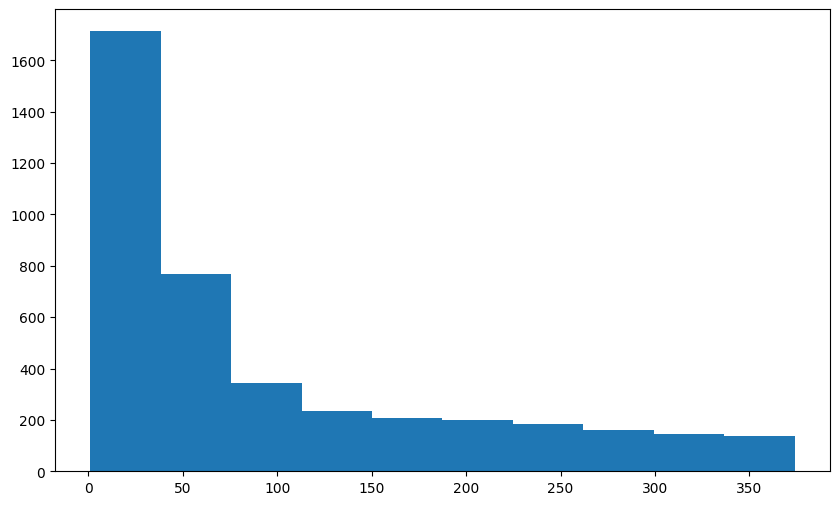

In [10]:
import matplotlib.pyplot as plt
import numpy as np
plt.hist(customers.Recency)
plt.show() 

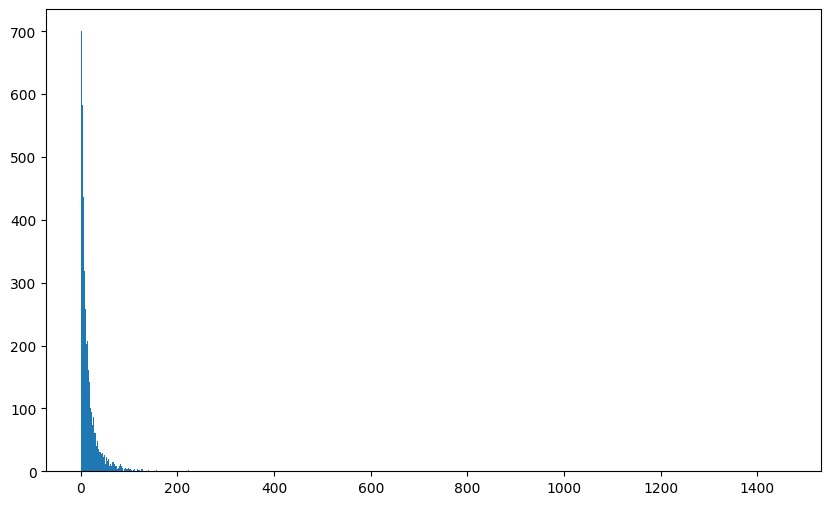

In [11]:
import matplotlib.pyplot as plt
import numpy as np
plt.hist(customers.Frequency, bins='auto')
plt.show() 

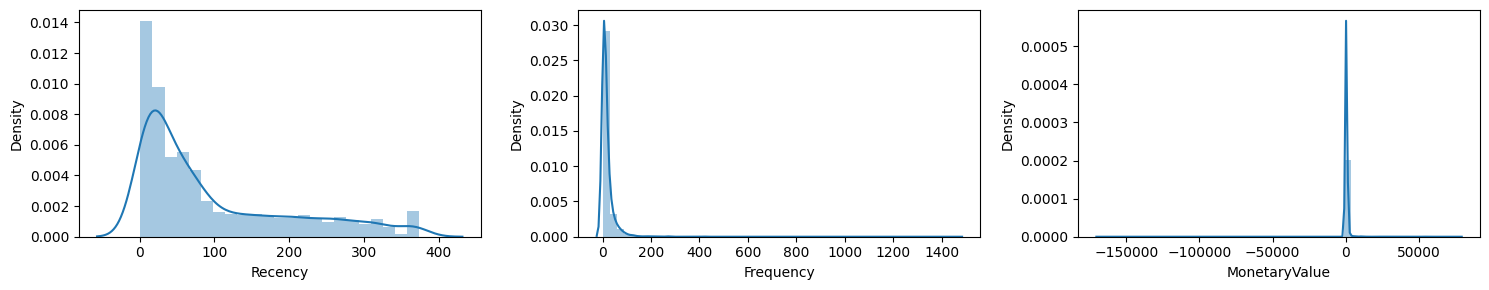

In [12]:
n=3
nf = [i for i in customers.columns]

plt.figure(figsize=[15,3*math.ceil(len(nf)/n)])
for c in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/n),n,c+1)
    sns.distplot(customers[nf[c]])
plt.tight_layout()
plt.show() 

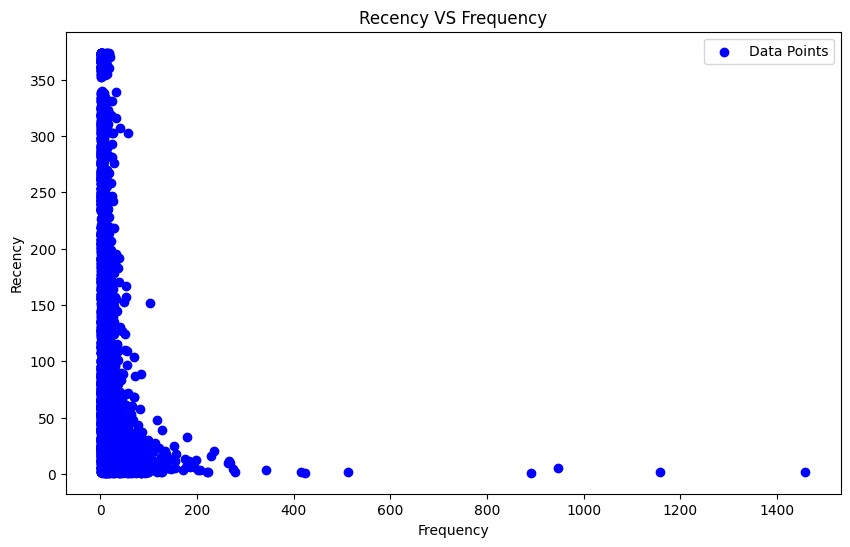

In [13]:
fig, ax = plt.subplots()
x = customers.Frequency
y = customers.Recency
ax.scatter(x, y, color='blue', label='Data Points')
ax.set_xlabel('Frequency')
ax.set_ylabel('Recency')
plt.title('Recency VS Frequency')
plt.legend()
plt.show()

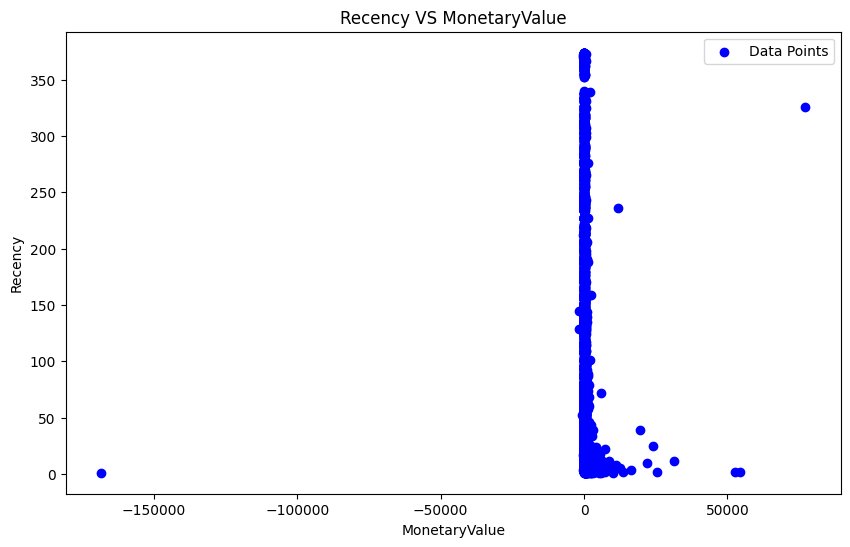

In [14]:
fig, ax = plt.subplots()
x = customers.MonetaryValue
y = customers.Recency
ax.scatter(x, y, color='blue', label='Data Points')
ax.set_xlabel('MonetaryValue')
ax.set_ylabel('Recency')
plt.title('Recency VS MonetaryValue')
plt.legend()
plt.show()

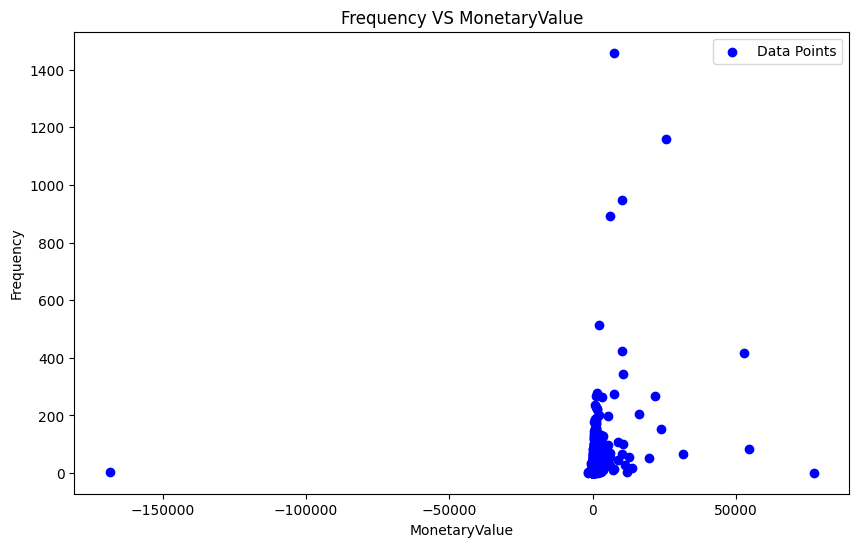

In [15]:
fig, ax = plt.subplots()
x = customers.MonetaryValue
y = customers.Frequency
ax.scatter(x, y, color='blue', label='Data Points')
ax.set_xlabel('MonetaryValue')
ax.set_ylabel('Frequency')
plt.title('Frequency VS MonetaryValue')
plt.legend()
plt.show()

#### To tackle the skewness, we make the use of transformations:
1. BoxCox
2. Log 
3. Sqrt 

In [16]:
cutomers_logT = customers.copy(deep=True)
cutomers_sqrtT = customers.copy(deep=True)
cutomers_cbrtT = customers.copy(deep=True)
cutomers_bxcxT = customers.copy(deep=True)


In [17]:

for i in customers.columns:
    cutomers_logT[i] = np.log(customers[i])
    cutomers_sqrtT[i] = np.sqrt(customers[i])
    cutomers_cbrtT[i] = np.cbrt(customers[i])
    if i!='MonetaryValue':
        cutomers_bxcxT[i] = stats.boxcox(customers[i])[0]

In [18]:
import scipy
from scipy.stats import skew 


In [19]:
skewcalc = pd.DataFrame(columns = ['Transformation','Recency','Frequency','MonetaryValue'])

In [20]:
print(skew(customers.Recency, axis=0, bias=True))
print(skew(customers.Frequency, axis=0, bias=True))
print(skew(customers.MonetaryValue, axis=0, bias=True))
skewcalc = skewcalc._append({'Transformation': ['None'] ,'Recency':[skew(customers.Recency, axis=0, bias=True)],'Frequency':[skew(customers.Frequency, axis=0, bias=True)],'MonetaryValue':[skew(customers.MonetaryValue, axis=0, bias=True)] }, ignore_index = True)

1.1889733424996805
17.700978061749407
-25.892208952176592


In [21]:

print(skew(cutomers_logT.Recency, axis=0, bias=True))
print(skew(cutomers_logT.Frequency, axis=0, bias=True))
print(skew(cutomers_logT.MonetaryValue, axis=0, bias=True))
skewcalc = skewcalc._append({'Transformation': ['Log'] ,'Recency':[skew(cutomers_logT.Recency, axis=0, bias=True)],'Frequency':[skew(cutomers_logT.Frequency, axis=0, bias=True)],'MonetaryValue':[skew(cutomers_logT.MonetaryValue, axis=0, bias=True)] }, ignore_index = True)

-0.4958741503954887
0.13371097212837377
nan


In [22]:
print(skew(cutomers_cbrtT.Recency, axis=0, bias=True))
print(skew(cutomers_cbrtT.Frequency, axis=0, bias=True))
print(skew(cutomers_cbrtT.MonetaryValue, axis=0, bias=True))
skewcalc = skewcalc._append({'Transformation': ['Cube Root'] ,'Recency':[skew(cutomers_cbrtT.Recency, axis=0, bias=True)],'Frequency':[skew(cutomers_cbrtT.Frequency, axis=0, bias=True)],'MonetaryValue':[skew(cutomers_cbrtT.MonetaryValue, axis=0, bias=True)] }, ignore_index = True)

0.26879302524720655
1.6283138512547428
0.36078057931212704


In [23]:
print(skew(cutomers_bxcxT.Recency, axis=0, bias=True))
print(skew(cutomers_bxcxT.Frequency, axis=0, bias=True))
print(skew(cutomers_bxcxT.MonetaryValue, axis=0, bias=True))
skewcalc = skewcalc._append({'Transformation': ['BoxCox'] ,'Recency':[skew(cutomers_bxcxT.Recency, axis=0, bias=True)],'Frequency':[skew(cutomers_bxcxT.Frequency, axis=0, bias=True)],'MonetaryValue':[skew(cutomers_bxcxT.MonetaryValue, axis=0, bias=True)] }, ignore_index = True)

-0.07045465130106617
0.007259597019609291
-25.892208952176592


In [24]:
skewcalc

,Transformation,Recency,Frequency,MonetaryValue
0,[None],[1.1889733424996805],[17.700978061749407],[-25.892208952176592]
1,[Log],[-0.4958741503954887],[0.13371097212837377],[nan]
2,[Cube Root],[0.26879302524720655],[1.6283138512547428],[0.36078057931212704]
3,[BoxCox],[-0.07045465130106617],[0.007259597019609291],[-25.892208952176592]


#### Hence we choose BoxCox for Recency and Frequency and use Log Transform for MonetaryValue

In [25]:
customers_fix = pd.DataFrame()
customers_fix["Recency"] = stats.boxcox(customers['Recency'])[0]
customers_fix["Frequency"] = stats.boxcox(customers['Frequency'])[0]
customers_fix["MonetaryValue"] = pd.Series(np.cbrt(customers['MonetaryValue'])).values
customers_fix.head()

,Recency,Frequency,MonetaryValue
0,9.860873,0.000000,42.576995
1,1.208121,3.072986,8.379998
2,9.802817,1.555020,7.626133
3,3.823360,2.556353,8.330963
4,9.735160,0.682921,3.500680


In [26]:
customers_fix.shape

(4092, 3)

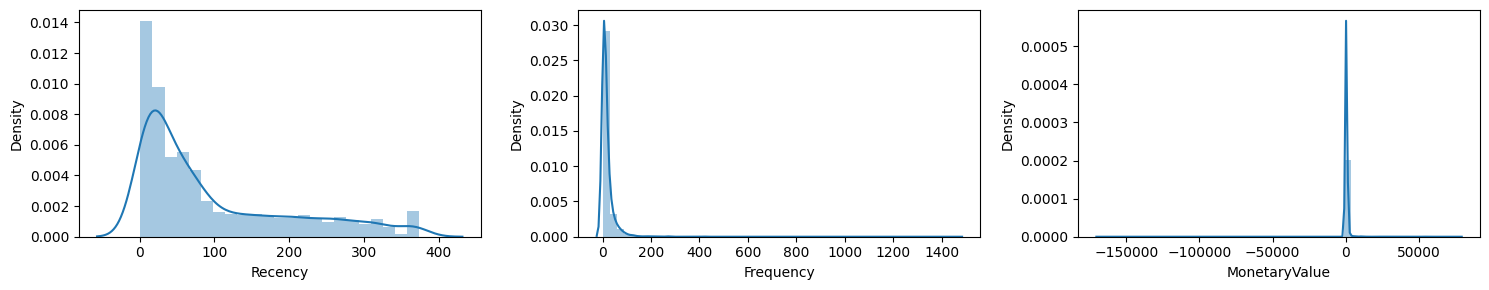

In [27]:
n=3
nf = [i for i in customers_fix.columns]

plt.figure(figsize=[15,3*math.ceil(len(nf)/n)])
for c in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/n),n,c+1)
    sns.distplot(customers[nf[c]])
plt.tight_layout()
plt.show()

In [28]:
customers_fix = customers_fix.dropna()

In [29]:
scaler = StandardScaler()
scaler.fit(customers_fix)
customers_norm = scaler.transform(customers_fix)
customers_norm = pd.DataFrame(customers_norm,columns = customers_fix.columns)

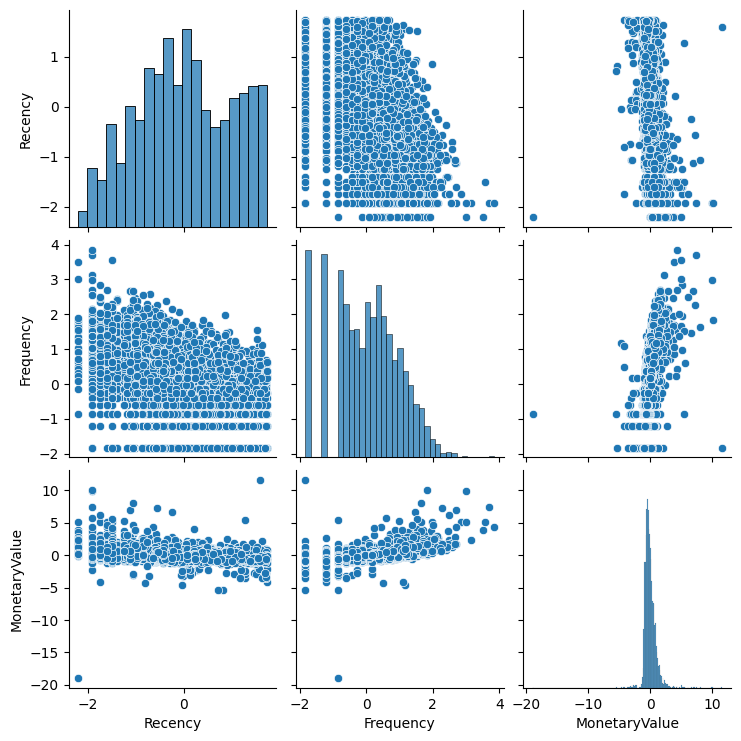

In [30]:
sns.pairplot(customers_norm)

#### Data Modeling

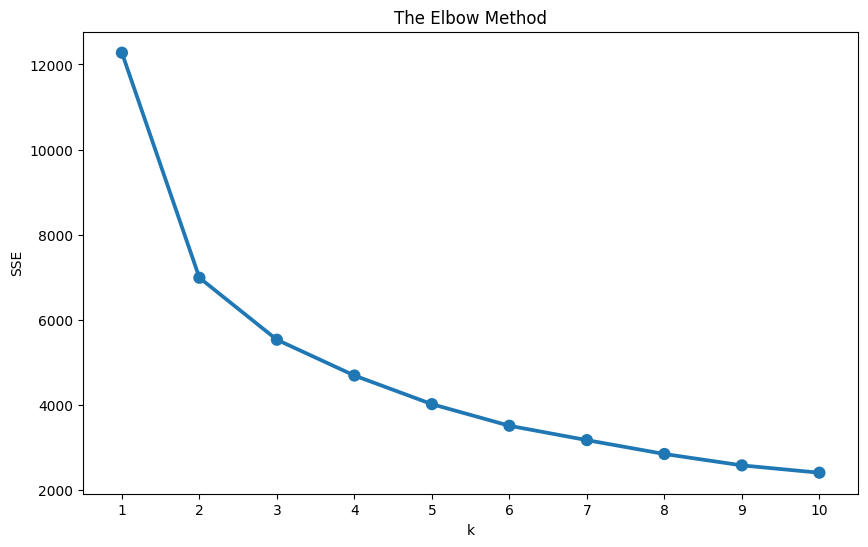

In [31]:
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customers_norm)
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid

#Elbow Plot    
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [32]:
model = KMeans(n_clusters=4, random_state=42)
model.fit(customers_norm)

customers["Cluster"] = model.labels_
customers.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']}).round(2)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0         18.13     63.15       1628.91   688
1        181.39      2.48        -93.52  1161
2         21.21     12.47        167.83  1168
3        136.32     13.11        223.27  1075

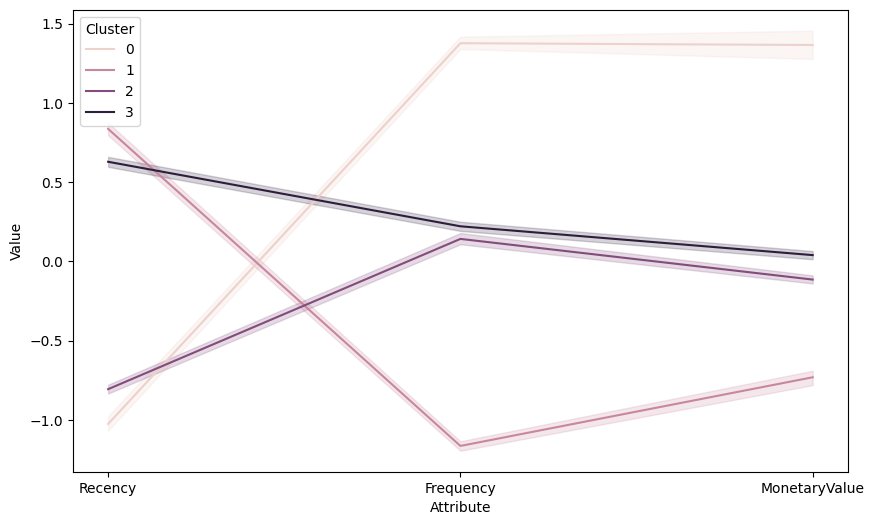

In [33]:
# Assuming customers is a DataFrame with an index and the calculations for customers_normalized are done wcześniej (previously)

# Create the normalized DataFrame
df_normalized = pd.DataFrame(customers_norm, columns=['Recency', 'Frequency', 'MonetaryValue'])

# Add the 'ID' column using the original index (assuming it's numeric)
df_normalized['ID'] = customers.index.to_numpy()  # Assuming numeric index

# Add the 'Cluster' column using model.labels_
df_normalized['Cluster'] = model.labels_

# Reset the index to create a single-level index for melting (optional)
# df_normalized = df_normalized.reset_index(drop=True)  # Drop the old index if needed

# Melt the data (ensure 'ID' and 'Cluster' are strings or categories for melting)
df_nor_melt = pd.melt(df_normalized,
                    id_vars=['ID', 'Cluster'],
                    value_vars=['Recency', 'Frequency', 'MonetaryValue'],
                    var_name='Attribute',
                    value_name='Value')

# Visualize the melted data
sns.lineplot(x='Attribute', y='Value', hue='Cluster', data=df_nor_melt)
plt.show()


In [34]:
customers.to_csv('file1.csv')